In [34]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow
# Loading the machine learning packages 
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import preprocessing 
from sklearn.metrics import roc_curve
# from tensorflow.examples.tutorials.mnist import input_data
from sklearn import datasets, svm, metrics
# from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml

# importing one hot encoder from sklearn 
from sklearn.preprocessing import OneHotEncoder 

In [0]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [0]:
# importing the Mnist data

# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
mnist = fetch_openml('mnist_784', cache=False)


# X = X[0:100,:]
# y = y[]

In [0]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
##selecting a small sample out of 70k to speed up coding and fix bugs
samples = 100
X = X[0:samples][:]
y = y[0:samples]

9


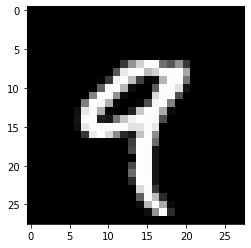

In [38]:
i = 4
plt.imshow(X[i][:].reshape(28,28),cmap='gray')
print(y[i])
plt.show()

In [39]:
y = y.reshape(-1,1)
onehotencoder = OneHotEncoder() 
y_onehot = onehotencoder.fit_transform(y).toarray() 
eps = 43
X = X*eps/np.max(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.25, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Preprocessing done X train has training set while X_test has the validation det. Y is in one hot encoding. X's pixels are scaled from 0-1. 




In [0]:
#user defined inputs:
t_mp =0.02
t_ref = 0.001
alpha = 7
n_w = 0.003
n_th = 0.1*n_w
beta = 10
l = 0.03
rho = 0.0002

n_in= 784#must be 28*28
n_hidden = 200#variable
n_out= 10
epochs = 100




Here m represents the no of synapse. As the it is a fully connected network nno of synapse in ith layer is equal to no of node in i-1 layer. In input layer hash one synapse only.

W[i][j] represent the weight of ith neuron of a layer connected to jth neuron of the next layer

In [0]:
m_in = 1
m_hidden = n_in
m_out = n_hidden

w_in = [random.uniform(-1*math.sqrt(3/m_in),1*math.sqrt(3/m_in)) for i in range(n_in)]
w_hidden = [[random.uniform(-1*math.sqrt(3/m_hidden),1*math.sqrt(3/m_hidden)) for i in range (m_hidden)] for j in range(n_hidden)]
w_out = [[random.uniform(-1*math.sqrt(3/m_out),1*math.sqrt(3/m_out)) for i in range(m_out)] for j in range(n_out)]

vth_in = [alpha*math.sqrt(3/m_in) for i in range(n_in)]
vth_hidden = [alpha*math.sqrt(3/m_hidden) for i in range(n_hidden)]
vth_out = [alpha*math.sqrt(3/m_out) for i in range(n_out)]



In [0]:
# this fundtion takes in the mean and generates the no of spikes in time ms second.
# gives the index value when it spikes. if spikes = [10,20,40]

def gen_spike(mean,time):#time is in ms
  A = [random.uniform(0,1) for i in range(time)]
  threshold = mean/time
  spikes = []
  count = 0 
  for i in range(len(A)):
    if A[i] < threshold:
      spikes.append(i)
      # count= count +1
  # print(len(spikes))
  return spikes
# stimulus =A[A<threshold];



In [0]:
inputs = []
img = 1
time = 1000#1 s for each image
for i in X_train[img]:
  inputs.append( gen_spike(i,time))# inputs tell me which neurons recieve spike.inputs[k] has input spike times of kth input neuron
spike_time = [ [] for i in range(time+1)]
for i in range(len(inputs)):
  for j in inputs[i]:
    spike_time[j].append(i)# at a perticular time j which all neurons spike is given by spike_time[j]

In [0]:
in_hidden = [[[] for i in range(m_hidden)] for j in range(n_hidden)]

In [0]:
hid_ispikes = [[] for i in range(time+1)]
a_in = [[] for i in range(n_in)]#ouput spike of input layer. a_in[j] has spike time of jth neuron

nin_vmp_t=  [[0,0] for i in range(n_in)]# collects infor mation of jth neuron after last inputspike. vmp and time
pre_spike = 0# time when last ouputspike occured of this layer
for i in range(1,time+1):#1 ms interval 
  # for i in range(n_in):
  next_spike = pre_spike 
  has_spiked = {}
  for j in spike_time[i]:
    # if last_v [j] == []:# if jth no input spike before:
    # #   v_pre = 0
    # #   t_pre = 0
    # # else:
    # #   v_pre = last_v[j][0]
    # #   t_pre = last_v[j][1]
    delta_t = (pre_spike - i)/1000
    # if delta_t < t_ref :
    w_dyn = min((delta_t/t_ref)**2,1)
    nin_vmp_t[j][0] = nin_vmp_t[j][0]*math.exp( ( i - nin_vmp_t[j][1]) / (1000*t_mp))  + w_dyn*w_in[j]
    nin_vmp_t[j][1] = i
    if nin_vmp_t[j][0] > vth_in[j] and j not in has_spiked:
      nin_vmp_t[j][0] = 0
      next_spike = i
      a_in[j].append(i)
      hid_ispikes[i].append(j)
      has_spiked[j] =1
  pre_spike = next_spike



In [0]:
###layer 2 now. it has input spike in hid_spike. hid_ispike[i] has neurons of inputlayer that spiked at ith ms.
##a_in[j] has the time when jth neuron spiked
a_hidden = [[] for i in range(n_hidden)]#ouput spike of hidden layer
out_ispikes = [[] for i in range(time+1)]

pre_spike = 0
hid_vmp_t=  [[0,0] for i in range(n_hidden)]
for i in range(1,time+1):
  next_spike = pre_spike
  has_spiked = {}
  for ispike in hid_ispikes[i]:
    for j in range(n_hidden):
      #time instant:::::i
      #inputspike from ispike
      # curr neuron ::::j
      delta_t = (pre_spike - i)/1000
      w_dyn = min((delta_t/t_ref)**2,1)
      hid_vmp_t[j][0] = hid_vmp_t[j][0]*math.exp( ( i - hid_vmp_t[j][1]) / (1000*t_mp))  + w_dyn*w_hidden[j][ispike]
      hid_vmp_t[j][1] = i
      if hid_vmp_t[j][1]> vth_hidden[j] and j not in has_spiked:
        hid_vmp_t[j][0] = 0
        next_spike = i
        a_hidden[j].append(i)
        out_ispikes[i].append(j)
        has_spiked[j]= 1
  pre_spike = next_spike

In [0]:
###output now. it has input spike in out_ispike. out_ispike[i] has neurons of inputlayer that spiked at ith ms.
##a_in[j] has the time when jth neuron spiked
a_out = [[] for i in range(n_out)]#ouput spike of ouput layer
pre_spike = 0
out_vmp_t=  [[0,0] for i in range(n_out)]
for i in range(1,time+1):
  next_spike = pre_spike
  has_spiked = {}
  for ispike in out_ispikes[i]:
    for j in range(n_out):
      #time instant:::::i
      #inputspike from ispike
      # curr neuron ::::j
      delta_t = (pre_spike - i)/1000 
      w_dyn = min((delta_t/t_ref)**2,1)
      out_vmp_t[j][0] = out_vmp_t[j][0]*math.exp( ( i - out_vmp_t[j][1]) / (1000*t_mp))  + w_dyn*w_out[j][ispike]
      out_vmp_t[j][1] = i
      if out_vmp_t[j][1]> vth_out[j] and j not in has_spiked  :
        out_vmp_t[j][0] = 0
        next_spike = i
        a_out[j].append(i)
        has_spiked[j] =1

  pre_spike = next_spike





In [60]:
# print(spike_time[time-1])
print(np.max(spike_time))

[686]


In [70]:
# print(hid_ispikes)
# print(out_ispikes)
print(len(a_out[2]))
print(a_out)

276
[[33, 41, 44, 47, 50, 53, 59, 62, 64, 66, 76, 79, 80, 83, 85, 87, 88, 92, 96, 97, 99, 100, 106, 113, 114, 118, 123, 128, 129, 130, 138, 144, 147, 149, 151, 152, 161, 162, 164, 169, 176, 178, 180, 181, 182, 194, 198, 201, 205, 206, 208, 212, 214, 217, 218, 219, 220, 221, 229, 235, 238, 242, 243, 247, 248, 258, 266, 272, 274, 283, 284, 285, 286, 290, 291, 292, 293, 294, 295, 296, 301, 307, 310, 311, 317, 328, 333, 334, 335, 337, 338, 345, 349, 350, 351, 365, 367, 368, 371, 374, 375, 378, 384, 387, 391, 392, 404, 408, 412, 417, 419, 420, 422, 423, 425, 426, 429, 431, 435, 439, 441, 443, 446, 447, 452, 457, 459, 463, 464, 466, 479, 486, 488, 492, 495, 497, 501, 502, 503, 507, 509, 512, 514, 516, 518, 523, 524, 528, 536, 541, 542, 544, 547, 554, 555, 558, 562, 564, 565, 570, 572, 573, 581, 592, 600, 602, 605, 607, 618, 620, 625, 627, 629, 630, 633, 634, 637, 638, 640, 647, 648, 652, 657, 659, 665, 667, 675, 684, 692, 694, 695, 698, 700, 705, 706, 710, 711, 712, 714, 722, 732, 733, 740, 